In [1]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 31 kB/s 
     |████████████████████████████████| 198 kB 45.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=efaf7dbb84683d6f9a0515c486f4fd6917b05b5679a18e587ebd07db7b2b3e59
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -cq https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"
!pip install findspark

In [4]:
import findspark
findspark.init()

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Загрузим файлы с данными:

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving negative.csv to negative.csv
Saving positive.csv to positive.csv
Saving stopwords.txt to stopwords.txt
User uploaded file "negative.csv" with length 24450101 bytes
User uploaded file "positive.csv" with length 26233379 bytes
User uploaded file "stopwords.txt" with length 2624 bytes


Загрузим данные и выберем 50% случайных позитивных и негативных твитов.
Объединим твиты в один датафрейм inputData:

In [8]:
df_neg = spark.read.csv('negative.csv',inferSchema=True, header = False, sep = ';').sample(withReplacement=True, fraction = 0.5).na.drop()
df_pos = spark.read.csv('positive.csv',inferSchema=True, header = False, sep = ';').sample(withReplacement=True, fraction = 0.5).na.drop()

In [9]:
df_neg.count()

47988

In [10]:
df_pos.count()

48898

In [11]:
inputData = df_neg.union(df_pos)

In [12]:
inputData.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)



In [13]:
inputData.count()

96886

Таблица состоит из 12 столбцов (описания в порядке возрастания индекса): – уникальный номер сообщения в системе twitter; – дата публикации сообщения (твита); – имя пользователя, опубликовавшего сообщение; – текст сообщения (твита); – поле, в котором указано к кому классу относится твит (положительный, отрицательный, нейтральный); – trep: количество реплаев к данному сообщению; – tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями; – tstcount: число всех сообщений пользователя в сети twitter; – tfol: количество фоловеров пользователя (тех людей, которые читают пользователя); – tfrien: количество друзей пользователя (те люди, которых читает пользователь); – listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [38]:
inputData.show(truncate = False)

+------------------+----------+---------------+-------------------------------------------------------------------------------------------------------------------------------+---+---+---+---+------+----+----+----+
|_c0               |_c1       |_c2            |_c3                                                                                                                            |_c4|_c5|_c6|_c7|_c8   |_c9 |_c10|_c11|
+------------------+----------+---------------+-------------------------------------------------------------------------------------------------------------------------------+---+---+---+---+------+----+----+----+
|408906762813579264|1386325944|dugarchikbellko|на работе был полный пиддес :| и так каждое закрытие месяца, я же свихнусь так D:                                              |-1 |0  |0  |0  |8064  |111 |94  |2   |
|408906818262687744|1386325957|nugemycejela   |Коллеги сидят рубятся в Urban terror, а я из-за долбанной винды не могу :(                       

Из столбцов выше нам понадобятся _c3 (сами твиты) и _c4 (оценка тональности - позитивный твит или негативный)

### Этап 1. Обработка данных

Прежде чем приступить к векторизации, нужно подготовить текстовые данные: разбить текст на отдельные токены, убрать стоп-слова и лишние данные (ссылки, хэштэги) и привести к начальной форме (лемматизация). Для первой задачи воспользуемся встроенными инструментами  Tokenizer и StopWordsRemover.

In [15]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

In [16]:
tokenizer = Tokenizer(inputCol="_c3", outputCol="tokenized")
tokenized = tokenizer.transform(inputData)
tokenized.show()

+------------------+----------+---------------+--------------------+---+---+---+---+------+----+----+----+--------------------+
|               _c0|       _c1|            _c2|                 _c3|_c4|_c5|_c6|_c7|   _c8| _c9|_c10|_c11|           tokenized|
+------------------+----------+---------------+--------------------+---+---+---+---+------+----+----+----+--------------------+
|408906762813579264|1386325944|dugarchikbellko|на работе был пол...| -1|  0|  0|  0|  8064| 111|  94|   2|[на, работе, был,...|
|408906818262687744|1386325957|   nugemycejela|Коллеги сидят руб...| -1|  0|  0|  0|    26|  42|  39|   0|[коллеги, сидят, ...|
|408906914723295232|1386325980|     capyvixowe|Обновил за каким-...| -1|  0|  0|  0|    35|  17|  34|   0|[обновил, за, как...|
|408906915704737792|1386325980|    nunejibaduq|Котёнка вчера нос...| -1|  0|  0|  0|   222|  62|  62|   0|[котёнка, вчера, ...|
|408906915704737792|1386325980|    nunejibaduq|Котёнка вчера нос...| -1|  0|  0|  0|   222|  62|  62|   

In [18]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
  stopwords = f.read().split()
  print(stopwords)


['а', 'будем', 'будет', 'будете', 'будешь', 'буду', 'будут', 'будучи', 'будь', 'будьте', 'бы', 'был', 'была', 'были', 'было', 'быть', 'в', 'вам', 'вами', 'вас', 'весь', 'во', 'вот', 'все', 'всё', 'всего', 'всей', 'всем', 'всём', 'всеми', 'всему', 'всех', 'всею', 'всея', 'всю', 'вся', 'вы', 'да', 'для', 'до', 'его', 'едим', 'едят', 'ее', 'её', 'ей', 'ел', 'ела', 'ем', 'ему', 'емъ', 'если', 'ест', 'есть', 'ешь', 'еще', 'ещё', 'ею', 'же', 'за', 'и', 'из', 'или', 'им', 'ими', 'имъ', 'их', 'к', 'как', 'кем', 'ко', 'когда', 'кого', 'ком', 'кому', 'комья', 'которая', 'которого', 'которое', 'которой', 'котором', 'которому', 'которою', 'которую', 'которые', 'который', 'которым', 'которыми', 'которых', 'кто', 'меня', 'мне', 'мной', 'мною', 'мог', 'моги', 'могите', 'могла', 'могли', 'могло', 'могу', 'могут', 'мое', 'моё', 'моего', 'моей', 'моем', 'моём', 'моему', 'моею', 'можем', 'может', 'можете', 'можешь', 'мои', 'мой', 'моим', 'моими', 'моих', 'мочь', 'мою', 'моя', 'мы', 'на', 'нам', 'нами', '

In [19]:
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered", stopWords=stopwords)
tokenized = remover.transform(tokenized)
tokenized.show(truncate=False)

+------------------+----------+---------------+-------------------------------------------------------------------------------------------------------------------------------+---+---+---+---+------+----+----+----+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|_c0               |_c1       |_c2            |_c3                                                                                                                            |_c4|_c5|_c6|_c7|_c8   |_c9 |_c10|_c11|tokenized                                                                                                                                              |filtered                                                                                                                    |
+-----------------

Для лемматизации воспользуемся библиотекой pymorphy, а также удалим ссылки на пользователей и хэштэги:

In [20]:
! pip install pymorphy2

     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 8.2 MB 10.0 MB/s 


In [21]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

lemma = lambda word: morph.parse(word)[0].normal_form
#Лемматизированный список стоп-слов

def clear_tweet(tweet):
    """Очистим твит от тэгов и ссылок и приведем слова к начальной форме """
    tweet = [w for w in [lemma(word) for word in tweet if not word.startswith(('#', '@', 'http', '"""'))] ]
    return tweet

In [22]:
data_x = []
for item in tokenized.collect():
  try:
    label = int(item._c4)
    if label == -1: label += 1
    data_x.append({'tweet':clear_tweet(item.filtered), 'label' : label})
  except ValueError:
    continue

X = spark.createDataFrame(data_x)
y = inputData.select('_c4')

In [23]:
X.show(truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------+
|label|tweet                                                                                                           |
+-----+----------------------------------------------------------------------------------------------------------------+
|0    |[работа, полный, пиддес, :|, каждый, закрытие, месяца,, свихнуться, d:]                                         |
|0    |[коллега, сидеть, рубиться, urban, terror,, из-за, долбать, винд, :(]                                           |
|0    |[обновить, какой-то, леший, surf,, теперь, работать, простоплеер, :(]                                           |
|0    |[котёнок, вчера, носик, разбила,, плакать, расстраиваться, :(]                                                  |
|0    |[котёнок, вчера, носик, разбила,, плакать, расстраиваться, :(]                                                  |
|0    |[микрофраза, :(, учиться,

Видно, что токенизатор не совсем правильно разделил предложения на токены, оставив смайлы и знаки препинания вместе со словами в случаях, где они не были разделены пробелом. Это сказалось на качестве лемматизации и предположительно скажется на результатах исследования, поскольку смайлы могут содержать значительную часть информации о тональности.

### Этап 2. Векторизация

В работе будут протестированы 2 типа векторов: tf-idf и word2vec. Для векторизации были использованы соответствующие инструменты spark.

In [24]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Word2Vec

In [25]:
hashingTF = HashingTF(inputCol="tweet", outputCol="rawFeatures", numFeatures=50)
featurizedData = hashingTF.transform(X)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
res_tfidf = idfModel.transform(featurizedData)

res_tfidf.show()

+-----+--------------------+--------------------+--------------------+
|label|               tweet|         rawFeatures|            features|
+-----+--------------------+--------------------+--------------------+
|    0|[работа, полный, ...|(50,[7,8,15,21,30...|(50,[7,8,15,21,30...|
|    0|[коллега, сидеть,...|(50,[7,19,25,27,3...|(50,[7,19,25,27,3...|
|    0|[обновить, какой-...|(50,[1,2,4,12,29,...|(50,[1,2,4,12,29,...|
|    0|[котёнок, вчера, ...|(50,[4,8,29,31,40...|(50,[4,8,29,31,40...|
|    0|[котёнок, вчера, ...|(50,[4,8,29,31,40...|(50,[4,8,29,31,40...|
|    0|[микрофраза, :(, ...|(50,[8,13,24,30,3...|(50,[8,13,24,30,3...|
|    0|[микрофраза, :(, ...|(50,[8,13,24,30,3...|(50,[8,13,24,30,3...|
|    0|[блин, начать, сн...|(50,[2,5,6,12,18,...|(50,[2,5,6,12,18,...|
|    0|[скоро, увидеть, ...|(50,[7,20,30,39,4...|(50,[7,20,30,39,4...|
|    0|[скоро, увидеть, ...|(50,[7,20,30,39,4...|(50,[7,20,30,39,4...|
|    0|[скоро, увидеть, ...|(50,[7,20,30,39,4...|(50,[7,20,30,39,4...|
|    0

In [40]:
word2Vec = Word2Vec(vectorSize=50, minCount=0, inputCol="tweet", outputCol="features")
model = word2Vec.fit(X)

res_w2v = model.transform(X)
res_w2v.show(truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Посмотрим, как выглядит векторное представление для некоторых "нестандартных" токенов:

In [49]:
for row in model.getVectors().collect():

  if row.word.startswith((':', '(', ')')):

    word, v = row 

    print("Text: %s => \nVector: %s\n" % (word, str(v)))

/content/spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Text: :-)))” => 
Vector: [0.006625475827604532,-0.004381208680570126,0.001788889174349606,0.0014226348139345646,0.006678775418549776,-0.00603580754250288,-0.009291138499975204,-0.0026848018169403076,0.010149030014872551,-0.009230399504303932,0.009713935665786266,-0.00265898578800261,-0.0030954540707170963,0.0017233940307050943,-0.002508820965886116,-0.009402026422321796,-0.002862429479137063,-0.00881304033100605,0.006625466514378786,0.001294827787205577,0.0031121147330850363,-0.0023370496928691864,0.008640284650027752,-0.007338168565183878,0.005501828622072935,0.007632438093423843,0.0064192782156169415,-0.008272512815892696,0.008469993248581886,-0.006069868337363005,-0.007590134162455797,-0.006372474599629641,-0.003462808206677437,-0.006361323408782482,0.009950034320354462,-0.0040094018913805485,0.009170643985271454,-0.008925016969442368,-0.005995078478008509,0.001447907998226583,-0.00581616535782814,-0.004197977017611265,0.003174230456352234,-0.010700838640332222,-0.00225849449634552,

### Этап 3. Классификация

В работе будут протестированы 3 типа классификаторов: RandomForest, SVM и DecisionTree.

In [27]:
train_n_test = res_w2v.randomSplit([0.7, 0.3]), res_tfidf.randomSplit([0.7, 0.3])

accs = []

In [28]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


for split_data in train_n_test:

  trainingData, testData = split_data

  rf = RandomForestClassifier(labelCol="label", numTrees=20)

  rf_w2v = rf.fit(trainingData)

  pred = rf_w2v.evaluate(testData)

  pred.predictions.show()

  evaluator = MulticlassClassificationEvaluator(
      labelCol="label", predictionCol="prediction", metricName="accuracy")

  accuracy = evaluator.evaluate(pred.predictions)

  accs.append(accuracy)
  print("Test Error = %g" % (1.0 - accuracy))
  print("Accuracy = %g" % accuracy)

/content/spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-----+--------------------+--------------------+--------------------+--------------------+----------+
|label|               tweet|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    0|                  []|          (50,[],[])|[6.59332453045439...|[0.32966622652272...|       1.0|
|    0|[, , , ж, болеют(...|[-0.1857343587492...|[6.44513322141960...|[0.32225666107098...|       1.0|
|    0|[, , верно,, день...|[-0.0658815011304...|[8.20553228179005...|[0.41027661408950...|       1.0|
|    0|[, , последний, в...|[-0.1938838251600...|[6.04293057517865...|[0.30214652875893...|       1.0|
|    0|[, , прости;(, хо...|[-0.2286674052476...|[7.80553126270695...|[0.39027656313534...|       1.0|
|    0|[, , спрашивать, ...|[-0.0721430805726...|[7.35555239410061...|[0.36777761970503...|       1.0|
|    0|[, , тоже(, быстр...|[-0.1961285836878...|[6.29675990373177...|[0.

In [29]:
from pyspark.ml.classification import LinearSVC

for split_data in train_n_test:

  trainingData, testData = split_data

  lsvc = LinearSVC(maxIter=50, regParam=1e-6)

  lsvcModel = lsvc.fit(trainingData)

  predictions = lsvcModel.transform(testData)

  predictions.show()

  accuracy = evaluator.evaluate(predictions)

  accs.append(accuracy)
  
  print("Test Error = %g" % (1.0 - accuracy))
  
  print("Accuracy = %g" % accuracy)

+-----+--------------------+--------------------+--------------------+----------+
|label|               tweet|            features|       rawPrediction|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|                  []|          (50,[],[])|[-1.1182319047456...|       1.0|
|    0|[, , , ж, болеют(...|[-0.1857343587492...|[-1.4309007216859...|       1.0|
|    0|[, , верно,, день...|[-0.0658815011304...|[0.13204459945447...|       0.0|
|    0|[, , последний, в...|[-0.1938838251600...|[-0.7591040410802...|       1.0|
|    0|[, , прости;(, хо...|[-0.2286674052476...|[1.15174440560017...|       0.0|
|    0|[, , спрашивать, ...|[-0.0721430805726...|[1.21821976790583...|       0.0|
|    0|[, , тоже(, быстр...|[-0.1961285836878...|[0.26285861530667...|       0.0|
|    0|[, , трогать, , ,...|[-0.3545068837702...|[-0.2925244051271...|       1.0|
|    0|[, , трогать, , ,...|[-0.3545068837702...|[-0.2925244051271...|       1.0|
|    0|[, , убра

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

for split_data in train_n_test:

  trainingData, testData = split_data

  dt = DecisionTreeClassifier()

  model = dt.fit(trainingData)

  predictions = model.transform(testData)

  accuracy = evaluator.evaluate(predictions)

  accs.append(accuracy)
    
  print("Test Error = %g" % (1.0 - accuracy))
    
  print("Accuracy = %g" % accuracy)

Test Error = 0.319945
Accuracy = 0.680055
Test Error = 0.42573
Accuracy = 0.57427


In [31]:
from matplotlib import pyplot as plt
import numpy as np

In [36]:
def draw_histogram(acc_matrix):

    vectors = ['word2vec', 'tf-idf']

    fig, ax = plt.subplots()

    width = 0.3

    x = np.arange(1, 4)

    for i in range(2):

        ax.bar(x + width*i, acc_matrix[:,i], width, label = vectors[i])

    ax.set_xticks(x + width / 2)

    ax.set_xticklabels(['RandomForest', 'SVM', 'DesTree'])

    ax.legend()

    plt.show()

In [50]:
accs

array([[0.69750043, 0.58152978],
       [0.72332356, 0.58414479],
       [0.68005516, 0.57426969]])

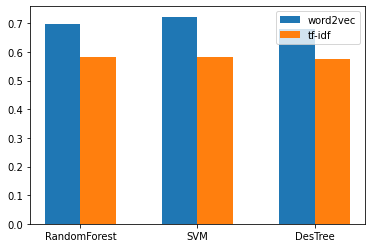

In [37]:
accs = np.array(accs).reshape(3,2)
draw_histogram(accs)

Видно, что результаты практически не различаются по классификаторам вне зависимости от вида векторов, однако все 3 классификатора показали лучшие результаты (точность 0.68-0.72) на word2vec в сравнении с tf-idf (0.57-0.58)